## Giới thiệu
Convolutional Neural Networks (CNNs) là một nhánh trong deep neural networks, thường được dùng để giải quyết các bài toán liên quan đến dữ liệu ảnh. Các mạng CNNs với đặc điểm là các lớp tích chập (convolutional layers) để trích xuất đặc trưng từ ảnh, lớp pooling dùng để giảm kích thước ảnh nhằm tăng hiệu suất tính toán và các lớp fully-connected thực hiện phân loại dựa trên các đặc trưng đã trích xuất.

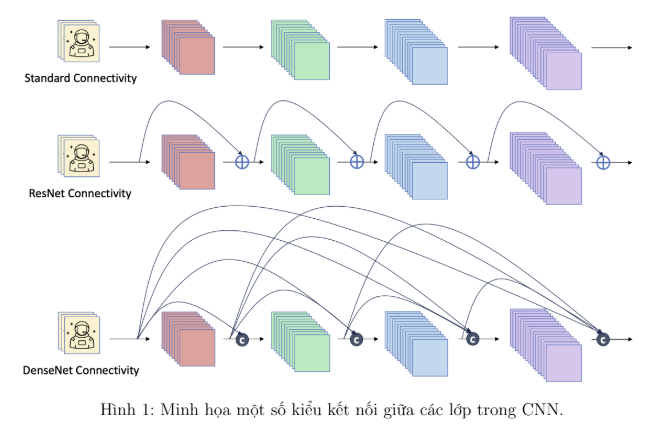

## Import các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Cố định giá trị ngẫu nhiên:
Để có thể tái tạo lại cùng một kết quả mô hình, chúng ta sẽ cố định cùng một giá trị ngẫu nhiên (seed) cho các thư viện có chứa các hàm tạo giá trị ngẫu nhiên:

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Đọc dữ liệu:
Sau khi tải và giải nén bộ dữ liệu, chúng ta sẽ được một thư mục chứa dữ liệu như sau:

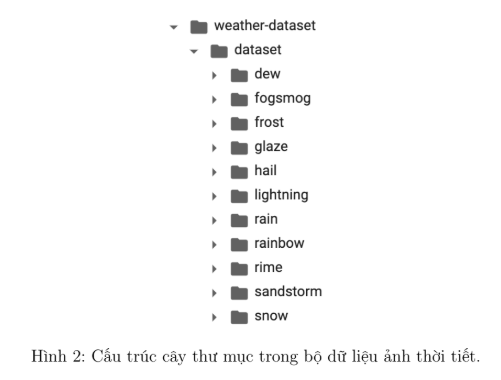

Để thuận tiện trong việc xây dựng PyTorch datasets, chúng ta sẽ ghi nhận thông tin về các classes, đường dẫn đến tất cả các ảnh cũng như label tương ứng như sau. Nhận thấy tên của các folder con trong thư mục weather-dataset/dataset cũng là tên class. Vì vậy, chúng ta sẽ đọc tên các folder này và đưa vào một dictionary như sau:

In [3]:
root_dir = '/content/drive/MyDrive/2023-AIO/AIO-MAIN/2024-module06/M06W01-07-Exercise/data/weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx : class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
    }
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
       img_path = os.path.join(class_dir, img_filename)
       img_paths.append(img_path)
       labels.append(label_idx)

## Chia bộ dữ liệu train, val, test:
Với danh sách đường dẫn ảnh và label, chúng ta sẽ chia thành ba bộ dữ liệu train, val, test sử dụng hàm train_test_split() của thư viện scikit-learn như sau:

In [4]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state=seed,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state=seed,
    shuffle = is_shuffle
)

## Xây dựng class pytorch datasets:
Chúng ta xây dựng class datasets cho bộ dữ liệu weather như sau:

In [5]:
class WeatherDataset(Dataset):
  def __init__(self, X, y, transform = None):
      self.transform = transform
      self.img_paths = X
      self.labels = y

  def __len__(self):
      return len(self.img_paths)

  def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      img = Image.open(img_path).convert("RGB")

      if self.transform:
           img = self.transform(img)

      return img, self.labels[idx]

## Xây dựng hàm tiền xử lý ảnh (transform):
Để đảm bảo dữ liệu ảnh đầu vào được đồng bộ về kích thước và giá trị, chúng ta tự định nghĩa hàm transform để tiền xử lý ảnh đầu vào như sau (không sử dụng thư viện **torchvision.transforms**):

Các kỹ thuật được áp dụng: resize ảnh, đổi về tensor và chuẩn hóa giá trị pixel về khoảng (0, 1).

In [6]:
def transform(img, img_size=(224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[... , :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0

  return normalized_img

## Khai báo datasets object cho ba bộ train, val, test:
Với class WeatherDataset và hàm chuẩn hóa ảnh, ta tạo ba object datasets tương ứng như sau:

In [7]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform = transform
)

val_dataset = WeatherDataset(
  X_val, y_val,
  transform = transform
)

test_dataset = WeatherDataset(
  X_test, y_test,
  transform = transform
)

## Khai báo dataloader:
Với ba object datasets trên, ta khai báo giá trị batch size và tạo dataloader như sau:

In [8]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
  train_dataset,
  batch_size = train_batch_size,
  shuffle = True
)
val_loader = DataLoader(
  val_dataset,
  batch_size = test_batch_size,
  shuffle = False
)
test_loader = DataLoader(
  test_dataset,
  batch_size = test_batch_size,
  shuffle = False
)

## Xây dựng model:
Trong phần này, chúng ta sẽ xây dựng class cho model deep learning với kiến trúc ResNet. Thông tin tổng quan về kiến trúc ResNet được thể hiện ở bảng sau:

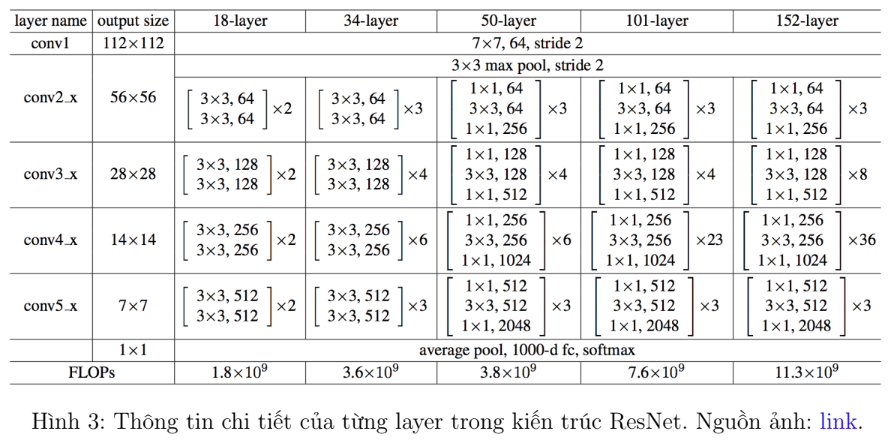

Đầu tiên, chúng ta sẽ xây dựng class **Residual Block**, đây là một thành phần đặc biệt của kiến trúc ResNet so với các mạng CNNs khác, có mô phỏng như hình sau:

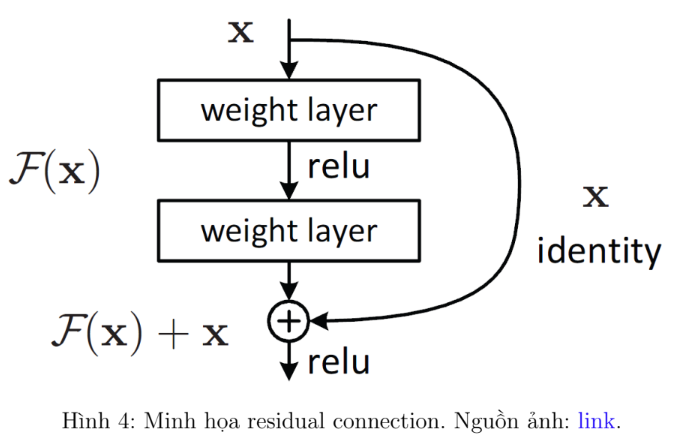

In [9]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
     super(ResidualBlock, self).__init__()
     self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
     self.batch_norm1 = nn.BatchNorm2d(out_channels)
     self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
     self.batch_norm2 = nn.BatchNorm2d(out_channels)

     self.downsample = nn.Sequential()
     if stride != 1 or in_channels != out_channels:
         self.downsample = nn.Sequential(
             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
             nn.BatchNorm2d(out_channels)
         )
     self.relu = nn.ReLU()

  def forward(self, x):
     shortcut = x.clone()
     x = self.conv1(x)
     x = self.batch_norm1(x)
     x = self.relu(x)
     x = self.conv2(x)
     x = self.batch_norm2(x)
     x += self.downsample(shortcut)
     x = self.relu(x)

     return x

In [10]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_blocks_lst, n_classes):
      super(ResNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
      self.batch_norm1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU()
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2 , padding=1)
      self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
      self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
      self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
      self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
      self.avgpool = nn.AdaptiveAvgPool2d(1)
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(512, n_classes)

  def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
      blocks = []
      first_block = residual_block(in_channels, out_channels, stride)
      blocks.append(first_block)

      for idx in range(1, n_blocks):
          block = residual_block(out_channels, out_channels, stride=1)
          blocks.append(block)

      block_sequential = nn.Sequential(*blocks)
      return block_sequential


  def forward(self, x):
      x = self.conv1(x)
      x = self.batch_norm1(x)
      x = self.maxpool(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.avgpool(x)
      x = self.flatten(x)
      x = self.fc1(x)

      return x

In [11]:
n_classes = len( list ( classes . keys () ) )
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
  residual_block = ResidualBlock,
  n_blocks_lst = [2 , 2 , 2 , 2],
  n_classes = n_classes
).to(device)

## Xây dựng hàm đánh giá model:
Ta xây dựng hàm đánh giá model với đầu vào là model, bộ dữ liệu đánh giá và hàm loss. Hàm này sẽ trả về giá trị loss và accuracy của model trên tập dữ liệu đầu vào:

In [12]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          losses.append(loss.item())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  loss = sum(losses) / len(losses)
  acc = correct / total

  return loss, acc

## Xây dựng hàm huấn luyện model:
Ta triển khai xây dựng hàm huấn luyện mô hình như sau:

In [13]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
      batch_train_losses = []

      model.train()
      for idx, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step ()

          batch_train_losses.append(loss.item())

          train_loss = sum(batch_train_losses) / len(batch_train_losses)
      train_losses.append(train_loss)

      val_loss, val_acc = evaluate(model, val_loader, criterion, device)
      val_losses.append(val_loss)

      print(f'EPOCH {epoch + 1}:\tTrain loss : {train_loss:.4f}\tVal loss : {val_loss:.4f}')
  return train_losses, val_losses

## Khai báo hàm loss và thuật toán tối ưu hóa:
Với bài toán phân loại ảnh, ta sử dụng hàm loss CrossEntropyLoss và thuật toán tối ưu hóa Stochastic Gradient Descent (SGD). Ngoài ra, ta cũng khai báo giá trị learning rate và số epochs:

In [14]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
     model.parameters(),
     lr=lr)

## Thực hiện huấn luyện:
Với tất cả các tham số đầu vào đã sẵn sàng, ta gọi hàm *fit()* để bắt đầu quá trình huấn luyện mô hình ResNet:

In [15]:
train_losses, val_losses = fit(model,
                               train_loader,
                               val_loader,
                               criterion,
                               optimizer,
                               device,
                               epochs)

EPOCH 1:	Train loss : 1.8819	Val loss : 2.3834
EPOCH 2:	Train loss : 1.3846	Val loss : 2.5898
EPOCH 3:	Train loss : 1.2222	Val loss : 2.6687
EPOCH 4:	Train loss : 1.1353	Val loss : 2.2341
EPOCH 5:	Train loss : 1.0776	Val loss : 1.5234
EPOCH 6:	Train loss : 1.0355	Val loss : 1.2971
EPOCH 7:	Train loss : 0.9792	Val loss : 1.1901
EPOCH 8:	Train loss : 0.9376	Val loss : 1.1184
EPOCH 9:	Train loss : 0.8959	Val loss : 1.2695
EPOCH 10:	Train loss : 0.8606	Val loss : 1.3156
EPOCH 11:	Train loss : 0.8564	Val loss : 1.9944
EPOCH 12:	Train loss : 0.8047	Val loss : 1.2847
EPOCH 13:	Train loss : 0.7791	Val loss : 1.7071
EPOCH 14:	Train loss : 0.7672	Val loss : 1.1768
EPOCH 15:	Train loss : 0.7187	Val loss : 2.3878
EPOCH 16:	Train loss : 0.7515	Val loss : 1.5813
EPOCH 17:	Train loss : 0.6799	Val loss : 1.3525
EPOCH 18:	Train loss : 0.6374	Val loss : 1.6702
EPOCH 19:	Train loss : 0.6488	Val loss : 3.4822
EPOCH 20:	Train loss : 0.6316	Val loss : 1.3620
EPOCH 21:	Train loss : 0.5848	Val loss : 1.1056
E

## Đánh giá mô hình:
Ta gọi hàm *evaluate()* để đánh giá performance của model trên hai tập val và test như sau:

In [16]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device)

print('Evaluation on val / test dataset')
print('Val accuracy : ', val_acc)
print('Test accuracy : ', test_acc)

Evaluation on val / test dataset
Val accuracy :  0.504734158776402
Test accuracy :  0.47016011644832606
